In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
# from time import process_time

In [2]:
def score_normal(X):
    
    # Sq(x[i]) = q'(x[i]) / q(x[i]) = -x[i]
    return -X

In [3]:
def kernel_function_TimeConsuming(X, h):
    """
    param X: mxN array
    """
    
    m, N = X.shape
    KernelMatrix = np.zeros((m, m))
    gradKernel = np.zeros((m, N, m))
    hessKernel = np.zeros((m, m))
    for i in range(m):
        for j in range(i+1, m):
            xi = X[i]
            xj = X[j]
            diffx = xi - xj
            kij = np.exp(- np.linalg.norm(diffx) ** 2 / (2 * h ** 2))
            KernelMatrix[i, j] = kij
            KernelMatrix[j, i] = kij
            # grad wrt to x is -(xi - yi)k(x, y) for all i
            # grad wrt to y is (xi - yi)k(x, y) for all i
            gradKernel[i, :, j] = - kij * diffx / (h ** 2)
            gradKernel[j, :, i] = kij * diffx / (h ** 2)
            # trace of second deriv (1 - (xi - yi)^2)k(x, y)
            hessKernel[i, j] = sum((1 - (diffx / h) ** 2)) * kij / (h ** 2)
            hessKernel[j, i] = hessKernel[i, j]
            
    return KernelMatrix, gradKernel, hessKernel

In [3]:
def diff_fn(X, Y):
    """
    X: m x N
    Y: m x N
    """
    
    X = np.expand_dims(X, axis=1) # m x 1 x N
    Y = np.expand_dims(Y, axis=0) # 1 x m x N
    diff = X - Y # m x m x N
    return diff

In [4]:
def diff_norm_sq_fn(X, Y):
    """
    X: m x N
    Y: m x N
    """
    
    diff = diff_fn(X, Y) # m x m x N
    diff_norm_sq = np.sum(diff**2, axis=-1) # m x m
    return diff_norm_sq

In [5]:
def kernel_function(X, h):
    """
    Args:
        X: m x N
        h: float
    """

    # time_start = process_time()

    m, N = X.shape

    diff_norm_sq = diff_norm_sq_fn(X, X) # m x m
    kernelMatrix = np.exp(- 1 / (2 * h**2) * diff_norm_sq) # m x m

    kernelMatrix_expand  = np.expand_dims(kernelMatrix, axis=-1) # m x m x 1
    diff = diff_fn(X, X) # m x m x N
    gradKernel1 = - 1 / (h**2) * diff * kernelMatrix_expand # m x m x N
    gradKernel2 = - gradKernel1 # m x m x N

    hessKernel = (N - (1 / h **2) * diff_norm_sq) * kernelMatrix / h ** 2

    # time_end = process_time()
    # print(f"this is kernel function: {time_end - time_start}")
    
    return kernelMatrix, gradKernel1, gradKernel2, hessKernel

    

In [7]:
def UqMatrix_TimeConsumingOne(X, h):

    m, N = X.shape
    Umatrix = np.zeros((m, m))
    KernelMatrix, gradKernel, hessKernel = kernel_function_TimeConsuming(X, h)
    for i in range(m):
        for j in range(m):
            sxi = - X[i]
            sxj = - X[j]
            kij = KernelMatrix[i, j]
            gradxi = gradKernel[i, :, j]
            gradxj = - gradxi
            trsum = hessKernel[i, j]
            uij = kij * np.dot(sxi, sxj) + np.dot(sxi, gradxj) + np.dot(gradxi, sxj) + trsum
            Umatrix[i, j] = uij
    return Umatrix

In [8]:
def UqMatrix_TimeConsuming(X, h):

    m, N = X.shape
    KernelMatrix, gradKernel, hessKernel = kernel_function_TimeConsuming(X, h)
    
    Umatrix = KernelMatrix * np.dot(X, X.T) + \
                np.einsum('...j, ...jk', X, gradKernel) + np.einsum('...j, ...jk', X, gradKernel).T + hessKernel
    
    return Umatrix

In [6]:
def UqMatrix(X, h):

    # time_start = process_time()

    kernelMatrix, gradKernel1, gradKernel2, hessKernel = kernel_function(X, h)
    X_expand = np.expand_dims(-X, axis = 1) # m x 1 x N
    Y_expand = np.expand_dims(-X, axis = 0) # 1 x m x N
    UMatrix = kernelMatrix * np.dot(X, X.T) + np.sum(X_expand * gradKernel2, axis = -1) + np.sum(Y_expand * gradKernel1, axis = -1) + hessKernel

    # time_end = process_time()
    # print(f"this is U Matrix: {time_end - time_start}")

    return UMatrix

In [7]:
def KSD(X, U):
    
    # time_start = process_time()

    m, _ = X.shape
    matDiag = np.sum(U.diagonal())
    matSum = U.sum()
    KSD = (matSum - matDiag) / (m * (m - 1))

    # time_end = process_time()
    # print(f"this is KSD: {time_end - time_start}")
    
    return KSD

In [8]:
def Bootstrap_KSD(U, size = 1000, epochshow = False):
    """
    
    """
    # time_start = process_time()

    m, _ = U.shape
    multi_prob = np.repeat((1 / m), m)

    Sstar = np.zeros(size)
    for i in range(size):
        Weight = np.random.multinomial(m, multi_prob)
        Wadjust = (Weight - 1) / m
        WMatrix = np.outer(Wadjust, Wadjust)
        SMatrix = WMatrix * U
        diag_sum = sum(SMatrix.diagonal())
        matrix_sum = SMatrix.sum()
        Si = matrix_sum - diag_sum
        Sstar[i] = Si
        if epochshow != False:
            if (i+1) % epochshow == 0:
                print(f"we are in epoch {i+1}")

    # time_end = process_time()
    # print(f"this is Bootstrap: {time_end - time_start}")

    return Sstar

In [24]:
def Bootstrap_KSD_TimeConsuming(U, bootstrape_size = 1000):

    # time_start = process_time()

    m, _ = U.shape
    multi_prob = np.repeat((1 / m), m)
    roughW = np.random.multinomial(m, multi_prob, size = bootstrape_size)
    Weight = (roughW - 1) / m
    Weight_expand = np.expand_dims(Weight, axis = 1)
    Weight_transpose = np.transpose(Weight_expand, (0, 2, 1))
    Weight_outer = Weight_expand * Weight_transpose
    SMatrix = Weight_outer * U
    diag_sum = np.sum(np.diagonal(SMatrix, axis1 = 1, axis2 = 2), axis = 1)
    matrix_sum = np.sum(np.sum(SMatrix, axis = 1), axis = 1)
    Sstar = matrix_sum - diag_sum

    # time_end = process_time()
    # print(f"this is Bootstrap: {time_end - time_start}")

    return Sstar

In [40]:
a = np.array([[1, 2, 3], [2, 3, 4]])
a_expand = np.expand_dims(a, axis = 1)
print(a_expand)
a_transpose = np.transpose(a_expand, (0, 2, 1))
print(a_transpose)
a_outer = a_expand * a_transpose
print(a_outer)
a_diag = np.diagonal(a_outer, axis1 = 1, axis2 = 2)
a_diag_sum = np.sum(a_diag, axis = 1)
print(a_diag_sum)
print(np.sum(a_outer, axis = 1))
a_sum = np.sum(np.sum(a_outer, axis = 1), axis = 1)
a_sum - a_diag_sum


[[[1 2 3]]

 [[2 3 4]]]
[[[1]
  [2]
  [3]]

 [[2]
  [3]
  [4]]]
[[[ 1  2  3]
  [ 2  4  6]
  [ 3  6  9]]

 [[ 4  6  8]
  [ 6  9 12]
  [ 8 12 16]]]
[14 29]
[[ 6 12 18]
 [18 27 36]]


array([22, 52])

In [9]:
def approx_pvalue(S, Sstar):
    """
    param S: unbiased estimation of KSD, scalar
    param Sstar: unbiased m bootstrap sample KSD
    """
    n = len(Sstar)
    TFarray = Sstar[Sstar >= S]
    count = len(TFarray)
    return count / n

In [10]:
def pValue_meanshift(samplesize, dim, bandwidth, meanvalue, bootstrapsize = 1000, iter = 100):
    """
    param stepvalue: 1D numpy array with dimension dim or boolean value False
    param covalue: 1D numpy array with dimension dim or boolean value False

    param
    """
    n = len(meanvalue)
    pvalue = np.zeros((n, iter))
    cov = np.identity(dim)
    for i in range(n):
        mi = meanvalue[i]
        mean = np.repeat(mi, dim)
        for j in range(iter):
            Multinormal_X = np.random.multivariate_normal(mean, cov, samplesize)
            UMatrix = UqMatrix(Multinormal_X, bandwidth)
            KSDvalue = KSD(Multinormal_X, UMatrix)
            #KSDstar = Bootstrap_KSD_TimeConsuming(UMatrix, bootstrape_size = bootstrapsize)
            KSDstar = Bootstrap_KSD(UMatrix, size = bootstrapsize, epochshow = False)
            pvalue[i, j] = approx_pvalue(KSDvalue, KSDstar)
        
        print(f"the {i + 1}th mean finished !")
    return pvalue


In [11]:
def pValue_meanshift_smallsample(samplesize, dim, bandwidth, meanvalue, bootstrapsize = 1000, iter = 100):
    """
    param stepvalue: 1D numpy array with dimension dim or boolean value False
    param covalue: 1D numpy array with dimension dim or boolean value False

    param
    """
    n = len(meanvalue)
    pvalue = np.zeros((n, iter))
    cov = np.identity(dim)
    for i in range(n):
        mi = meanvalue[i]
        mean = np.repeat(mi, dim)
        for j in range(iter):
            Multinormal_X = np.random.multivariate_normal(mean, cov, samplesize)
            UMatrix = UqMatrix(Multinormal_X, bandwidth)
            KSDvalue = KSD(Multinormal_X, UMatrix)
            KSDstar = Bootstrap_KSD_TimeConsuming(UMatrix, bootstrape_size = bootstrapsize)
            #KSDstar = Bootstrap_KSD(UMatrix, size = bootstrapsize, epochshow = False)
            pvalue[i, j] = approx_pvalue(KSDvalue, KSDstar)
        
        print(f"the {i + 1}th mean finished !")
    return pvalue


In [17]:
def pValue_varshift(samplesize, dim, varvalue, bootstrapsize = 1000, iter = 100):
    """
    param stepvalue: 1D numpy array with dimension dim or boolean value False
    param covalue: 1D numpy array with dimension dim or boolean value False

    param
    """
    n = len(varvalue)
    pvalue = np.zeros((n, iter))
    mean = np.zeros(dim)
    for i in range(n):
        vi = varvalue[i]
        cov = np.identity(dim) * vi
        for j in range(iter):
            Multinormal_X = np.random.multivariate_normal(mean, cov, samplesize)
            UMatrix = UqMatrix(Multinormal_X)
            KSDvalue = KSD(Multinormal_X, UMatrix)
            KSDstar = Bootstrap_KSD(UMatrix, size = bootstrapsize)
            pvalue[i, j] = approx_pvalue(KSDvalue, KSDstar)
    return pvalue

In [29]:
meanarray = np.linspace(0, 1, 6)

p_meanshift_1D = pValue_meanshift(100, 1, 1, meanvalue=meanarray, iter = 100)

the 1th mean finished !
the 2th mean finished !
the 3th mean finished !
the 4th mean finished !
the 5th mean finished !
the 6th mean finished !


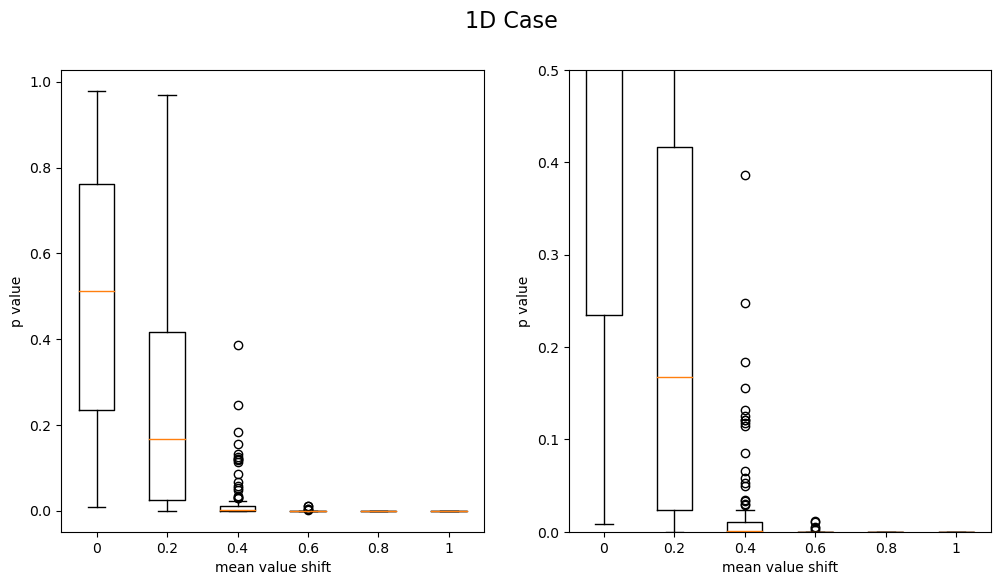

In [28]:
fig = plt.figure(figsize =(12, 6))
fig.suptitle("1D Case", fontsize = 16)

ax = fig.add_subplot(121)
ax.boxplot(p_meanshift_1D.T)
ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xlabel("mean value shift")
ax.set_ylabel("p value")

ax1 = fig.add_subplot(122)
ax1.boxplot(p_meanshift_1D.T)
ax1.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
ax1.set_xlabel("mean value shift")
ax1.set_ylabel("p value")
ax1.set_ylim(0, 0.5)

# show plot
plt.show()

In [13]:
p_meanshift_20D = pValue_meanshift(100, 20, meanvalue=meanarray, iter = 100)

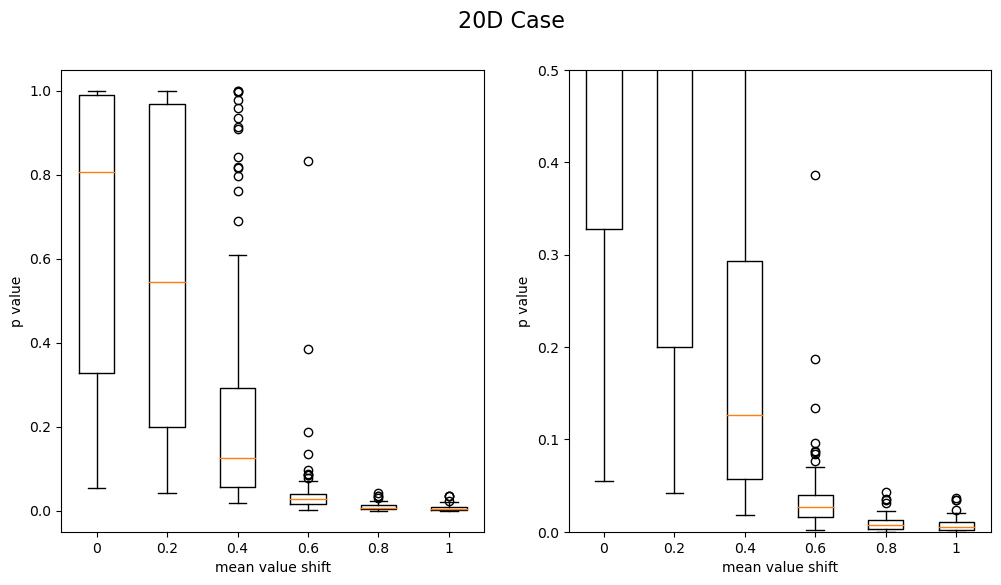

In [14]:
fig = plt.figure(figsize =(12, 6))
fig.suptitle("20D Case", fontsize = 16)

ax = fig.add_subplot(121)
ax.boxplot(p_meanshift_20D.T)
ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xlabel("mean value shift")
ax.set_ylabel("p value")

ax1 = fig.add_subplot(122)
ax1.boxplot(p_meanshift_20D.T)
ax1.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
ax1.set_xlabel("mean value shift")
ax1.set_ylabel("p value")
ax1.set_ylim(0, 0.5)
 
# show plot
plt.show()

In [25]:
mshift = np.array([0])
p_meanshift_10D = pValue_meanshift(100, 10, meanvalue=mshift, iter = 100)
p_meanshift_20D = pValue_meanshift(100, 20, meanvalue=mshift, iter = 100)
p_meanshift_30D = pValue_meanshift(100, 30, meanvalue=mshift, iter = 100)
p_meanshift_40D = pValue_meanshift(100, 40, meanvalue=mshift, iter = 100)
p_meanshift_50D = pValue_meanshift(100, 50, meanvalue=mshift, iter = 100)
p_meanshift_100D = pValue_meanshift(100, 100, meanvalue=mshift, iter = 100)

In [26]:
data = np.array([p_meanshift_10D[0], p_meanshift_20D[0], p_meanshift_30D[0], p_meanshift_40D[0], p_meanshift_50D[0], p_meanshift_100D[0]])

Text(0, 0.5, 'p value')

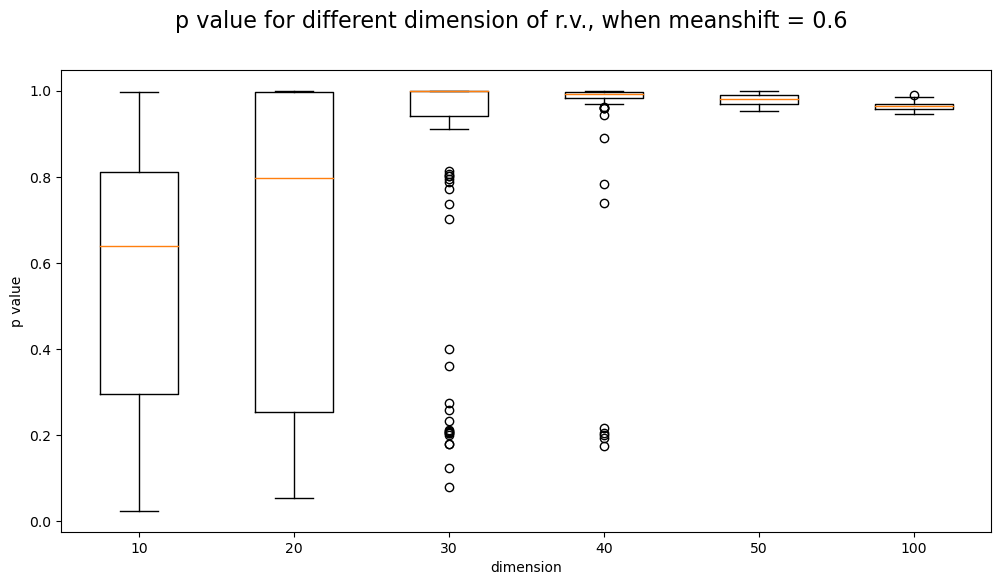

In [27]:
fig = plt.figure(figsize =(12, 6))
fig.suptitle("p value for different dimension of r.v., when meanshift = 0.6", fontsize = 16)

ax = fig.add_subplot(111)
ax.boxplot(data.T)
ax.set_xticklabels(["10", "20", "30", "40", "50", "100"])
ax.set_xlabel("dimension")
ax.set_ylabel("p value")

In [18]:
vararray = np.linspace(1, 3, 5)

p_varshift_1D = pValue_varshift(100, 1, varvalue=vararray, iter = 100)

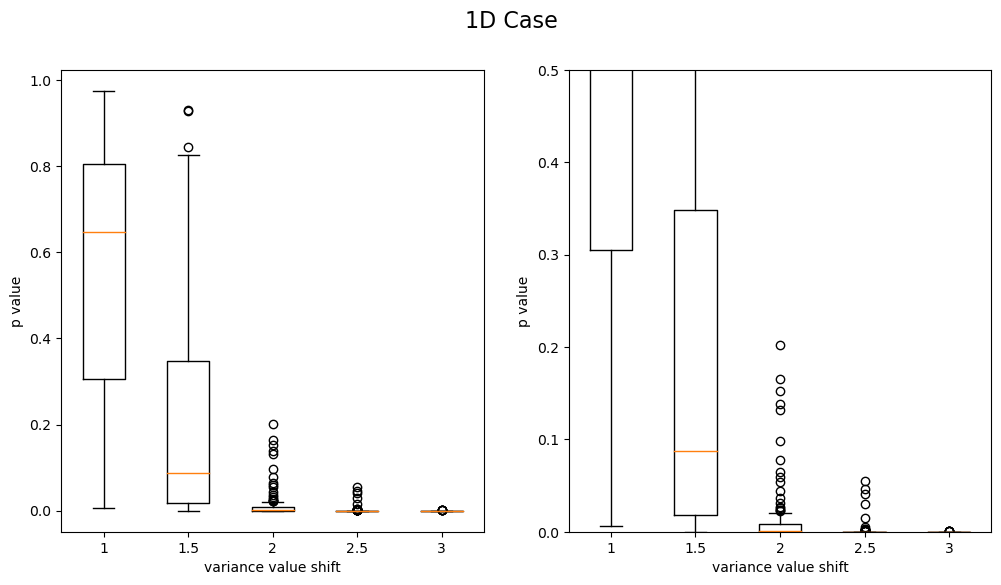

In [19]:
fig = plt.figure(figsize =(12, 6))
fig.suptitle("1D Case", fontsize = 16)

ax = fig.add_subplot(121)
ax.boxplot(p_varshift_1D.T)
ax.set_xticklabels([1, 1.5, 2, 2.5, 3])
ax.set_xlabel("variance value shift")
ax.set_ylabel("p value")

ax1 = fig.add_subplot(122)
ax1.boxplot(p_varshift_1D.T)
ax1.set_xticklabels([1, 1.5, 2, 2.5, 3])
ax1.set_xlabel("variance value shift")
ax1.set_ylabel("p value")
ax1.set_ylim(0, 0.5)

plt.show()

In [20]:
p_varshift_20D = pValue_varshift(100, 20, varvalue=vararray, iter = 100)

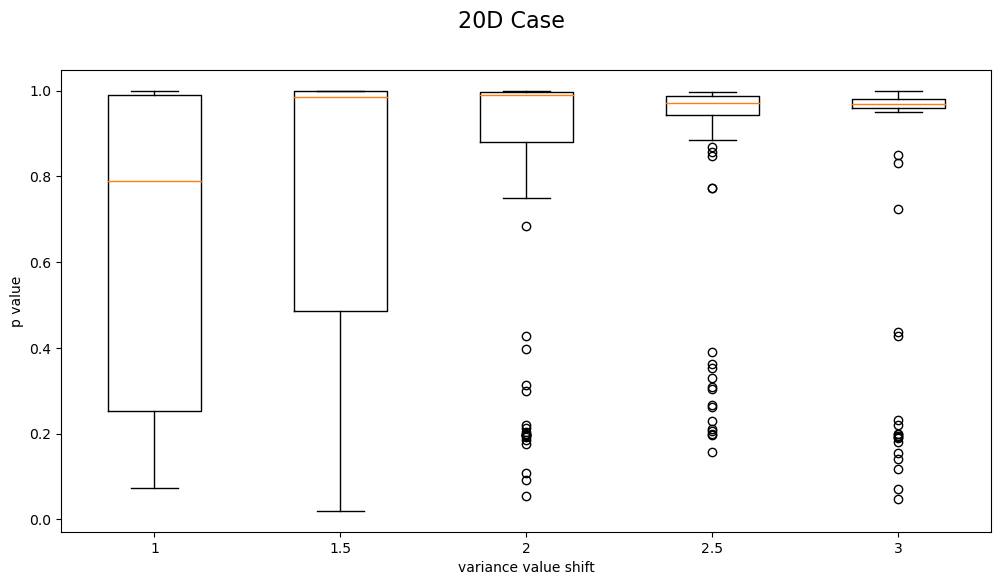

In [21]:
fig = plt.figure(figsize =(12, 6))
fig.suptitle("20D Case", fontsize = 16)

ax = fig.add_subplot(111)
ax.boxplot(p_varshift_20D.T)
ax.set_xticklabels([1, 1.5, 2, 2.5, 3])
ax.set_xlabel("variance value shift")
ax.set_ylabel("p value")

plt.show()

In [22]:
vshift = np.array([2])
p_varshift_1D = pValue_varshift(100, 1, varvalue=vshift, iter = 100)
p_varshift_2D = pValue_varshift(100, 2, varvalue=vshift, iter = 100)
p_varshift_5D = pValue_varshift(100, 5, varvalue=vshift, iter = 100)
p_varshift_10D = pValue_varshift(100, 10, varvalue=vshift, iter = 100)
p_varshift_15D = pValue_varshift(100, 15, varvalue=vshift, iter = 100)
p_varshift_20D = pValue_varshift(100, 20, varvalue=vshift, iter = 100)

In [23]:
data2 = np.array([p_varshift_1D[0], p_varshift_2D[0], p_varshift_5D[0], p_varshift_10D[0], p_varshift_15D[0], p_varshift_20D[0]])

Text(0, 0.5, 'p value')

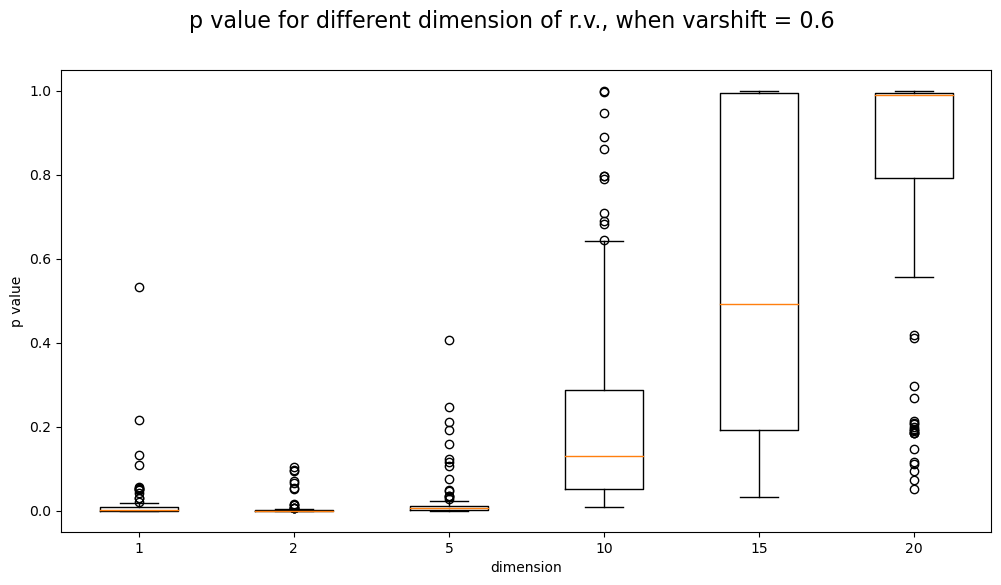

In [24]:
fig = plt.figure(figsize =(12, 6))
fig.suptitle("p value for different dimension of r.v., when varshift = 0.6", fontsize = 16)

ax = fig.add_subplot(111)
ax.boxplot(data2.T)
ax.set_xticklabels(["1", "2", "5", "10", "15", "20"])
ax.set_xlabel("dimension")
ax.set_ylabel("p value")

In [12]:
zeromean = np.array([0])

dim10_sieze100 = pValue_meanshift(100, 20, 1, meanvalue=zeromean, iter = 100)

the 1th mean finished !


In [13]:
dim10_sieze200 = pValue_meanshift(200, 20, 1, meanvalue=zeromean, iter = 100)

the 1th mean finished !


In [14]:
dim10_sieze400 = pValue_meanshift(400, 20, 1, meanvalue=zeromean, iter = 100)

the 1th mean finished !


In [15]:
dim10_sieze600 = pValue_meanshift(600, 20, 1, meanvalue=zeromean, iter = 100)

In [ ]:
dim10_sieze800 = pValue_meanshift(800, 20, 1, meanvalue=zeromean, iter = 100)

the 1th mean finished !


In [ ]:
dim10_sieze1000 = pValue_meanshift(1000, 20, 1, meanvalue=zeromean, iter = 100)

the 1th mean finished !


In [ ]:
data_dim = np.array([dim10_sieze100[0], dim10_sieze200[0], dim10_sieze400[0], dim10_sieze600[0], dim10_sieze800[0], dim10_sieze1000[0]])

NameError: name 'np' is not defined

In [ ]:
fig = plt.figure(figsize =(12, 6))
fig.suptitle("p value for different dimension of r.v., when varshift = 0.6", fontsize = 16)

ax = fig.add_subplot(111)
ax.boxplot(data_dim.T)
ax.set_xticklabels(["100", "200", "400", "600", "800", "1000"])
ax.set_xlabel("dimension")
ax.set_ylabel("p value")

NameError: name 'plt' is not defined